# Modeling the energy usage accross appliances in a low-energy house as a function of domestic and weather-related bariables -- Alex Arbisman

For this project, we are getting getting time, temperature, humidity, and weather variables from sensors within a low-energy house. We will use this to predict the total energy consumption across appliances in the house.

While this dataset is listed on the UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) It is originally mentioned in the paper, Data driven prediction models of energy use of appliances in a low-energy house, by Luis M.Candanedo, Véronique Feldheim, and Dominique Deramaix (https://www.sciencedirect.com/science/article/abs/pii/S0378778816308970?via%3Dihub).

In [212]:
## Core data packages
import pandas as pd
import numpy as np

## Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Misc
import time
from datetime import datetime

## Data Transformation
from scipy.stats import boxcox


## Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
import statsmodels.api as sm


## Model Fitting and Evaluation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [213]:
## Load in our cleaned data
start_time = time.time()
dat = pd.read_csv('energydata_complete.csv')
elapsed = time.time() - start_time

print("Loading Time: ", round(elapsed, 2), " seconds")
dat.shape

Loading Time:  0.1  seconds


(19735, 29)

In [214]:
dat.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [215]:
## We rename the columns in our energy dataset based off of their provied names in the UCI data explanation.
dat.rename(columns={'T1': 'tempKitchen',
                   'RH_1': 'humidKitchen',
                   'T2': 'tempLiving',
                   'RH_2': 'humidLiving',
                   'T3': 'tempLaundry',
                   'RH_3': 'humidLaundry',
                   'T4': 'tempOffice',
                   'RH_4': 'humidOffice',
                   'T5': 'tempBathroom',
                   'RH_5': 'humidBathroom',
                   'T6': 'tempOutsideBuilding',
                   'RH_6': 'humidOutsideBuilding',
                   'T7': 'tempIroning',
                   'RH_7': 'humidIroning',
                   'T8': 'tempTeenagerRoom',
                   'RH_8': 'humidTeenagerRoom',
                   'T9': 'tempParentRoom',
                   'RH_9': 'humidParentRoom',
                   'T_out': 'tempOutside',
                   'RH_out': 'humidOutside'}, inplace=True)

## Set all of the continous from float64 to float32
type_converts = {'Appliances' : 'int32',
                 'lights' : 'int32',
                 'tempKitchen' : 'int32',
                 'humidKitchen' : 'int32',
                 'tempLiving' : 'int32',
                 'humidLiving' : 'int32',
                 'tempLaundry' : 'int32',
                 'humidLaundry' : 'int32',
                 'tempOffice' : 'int32',
                 'humidOffice' : 'int32',
                 'tempBathroom' : 'int32',
                 'humidBathroom' : 'int32',
                 'tempOutsideBuilding' : 'int32',
                 'humidOutsideBuilding' : 'int32',
                 'tempIroning' : 'int32',
                 'humidIroning' : 'int32',
                 'tempTeenagerRoom' : 'int32',
                 'humidTeenagerRoom' : 'int32',
                 'tempParentRoom' : 'int32',
                 'humidParentRoom' : 'int32',
                 'tempOutside' : 'int32',
                 'humidOutside' : 'int32',
                 'Press_mm_hg' : 'int32',
                 'Windspeed' : 'int32',
                 'Visibility' : 'int32',
                 'Tdewpoint' : 'int32',
                 'rv1' : 'int32',
                 'rv2' : 'int32'}

dat = dat.astype(type_converts)
dat.dtypes

date                    object
Appliances               int32
lights                   int32
tempKitchen              int32
humidKitchen             int32
tempLiving               int32
humidLiving              int32
tempLaundry              int32
humidLaundry             int32
tempOffice               int32
humidOffice              int32
tempBathroom             int32
humidBathroom            int32
tempOutsideBuilding      int32
humidOutsideBuilding     int32
tempIroning              int32
humidIroning             int32
tempTeenagerRoom         int32
humidTeenagerRoom        int32
tempParentRoom           int32
humidParentRoom          int32
tempOutside              int32
Press_mm_hg              int32
humidOutside             int32
Windspeed                int32
Visibility               int32
Tdewpoint                int32
rv1                      int32
rv2                      int32
dtype: object

# Part 1: Basic Exploratory Data Analysis

In [216]:
dat.columns

Index(['date', 'Appliances', 'lights', 'tempKitchen', 'humidKitchen',
       'tempLiving', 'humidLiving', 'tempLaundry', 'humidLaundry',
       'tempOffice', 'humidOffice', 'tempBathroom', 'humidBathroom',
       'tempOutsideBuilding', 'humidOutsideBuilding', 'tempIroning',
       'humidIroning', 'tempTeenagerRoom', 'humidTeenagerRoom',
       'tempParentRoom', 'humidParentRoom', 'tempOutside', 'Press_mm_hg',
       'humidOutside', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

#### We can see that our response data has a pretty massive right skew. If not for that right tail, it would look fairly normally distributed.

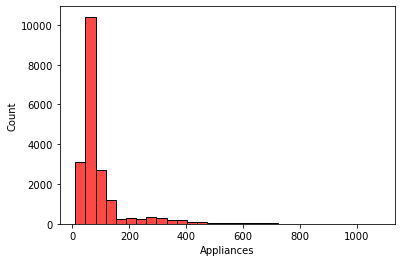

Mean usage: 97.69
Median usage: 60.0


In [217]:
## Generate a Basic Histogram
sns.histplot(dat.Appliances,bins = 30)
plt.show()

## The difference in Mean and Median suggests that outliers are pretty significant
print("Mean usage:", round(dat.Appliances.mean(), 2))
print("Median usage:", round(dat.Appliances.median(), 2))

#### Since we want to transform our response variable, we'll compare various transformation methods to see which one produces the most normally-distributed variable

Skewness of data: 3.386
Skewness of data (outlers removed): 3.347
Skewness of log(data): 1.166
Skewness of boxcox(data): -0.052
Skewness of boxcox(data) (outlers removed): 0.032


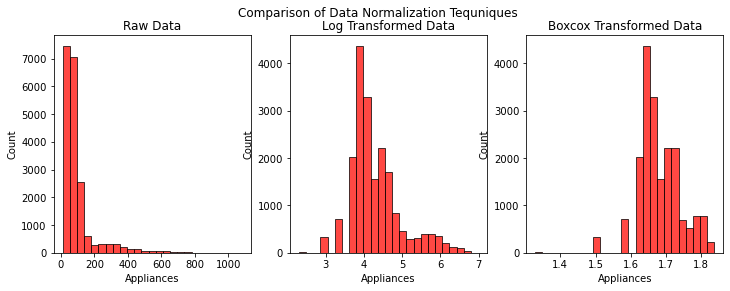

In [247]:
## We create our data transformations
log_appliances = np.log(dat.Appliances)
boxcox_appliances = pd.Series(boxcox(dat.Appliances)[0])

## Creating the plots
fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('Comparison of Data Normalization Tequniques')

sns.histplot(dat.Appliances,bins = 25, ax=axes[0])
axes[0].set_title('Raw Data')

sns.histplot(log_appliances, bins = 25, ax=axes[1])
axes[1].set_title('Log Transformed Data')

sns.histplot(boxcox_appliances, bins = 25, ax=axes[2], )
axes[2].set_title('Boxcox Transformed Data')
plt.xlabel('Appliances')

## Printing the exact skewness score
print("Skewness of data:", round(dat.Appliances.skew(), 3))
print("Skewness of data (outlers removed):", round(dat.Appliances[dat.Appliances < 1000].skew(), 3))
print("Skewness of log(data):", round(log_appliances.skew(), 3))
print("Skewness of boxcox(data):", round(boxcox_appliances.skew(), 3))
print("Skewness of boxcox(data) (outlers removed):", round(boxcox_appliances[boxcox_appliances > 1.4].skew(), 3))


We will go with a boxcox transformation, and drop the lone outlier variable

[Text(0.5, 0, '')]

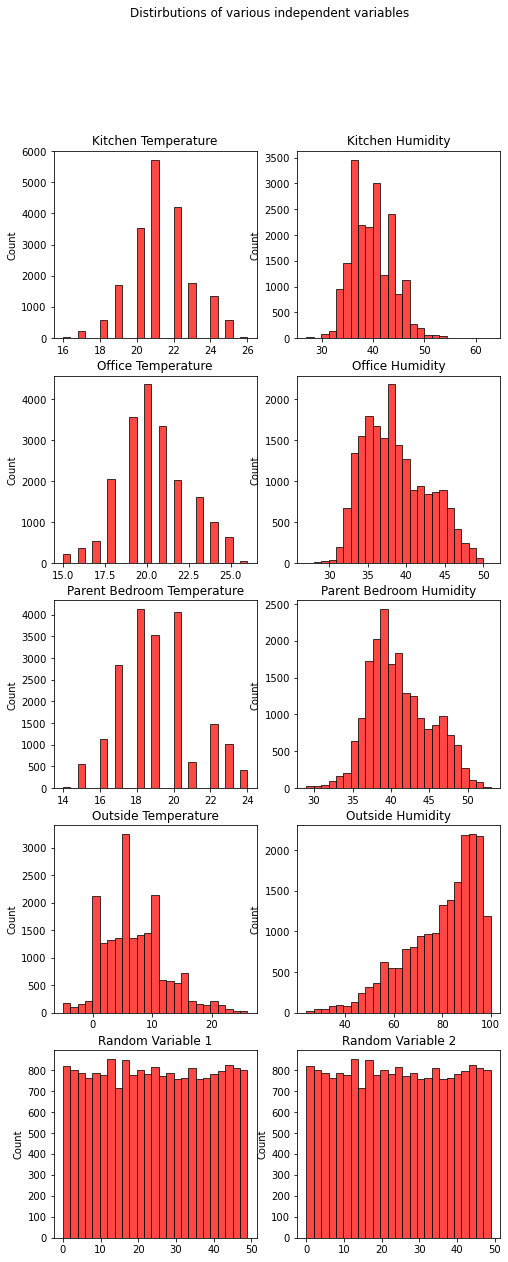

In [219]:
## We create our data transformations
log_appliances = np.log(dat.Appliances)
boxcox_appliances = pd.Series(boxcox(dat.Appliances)[0])

## Creating the plots
fig, axes = plt.subplots(5, 2, figsize=(8,20))
fig.suptitle('Distirbutions of various independent variables')

sns.histplot(dat.tempKitchen,bins = 25, ax=axes[0, 0])
axes[0, 0].set_title('Kitchen Temperature')
axes[0, 0].set(xlabel=None)

sns.histplot(dat.humidKitchen,bins = 25, ax=axes[0, 1])
axes[0, 1].set_title('Kitchen Humidity')
axes[0, 1].set(xlabel=None)

sns.histplot(dat.tempOffice,bins = 25, ax=axes[1, 0])
axes[1, 0].set_title('Office Temperature')
axes[1, 0].set(xlabel=None)

sns.histplot(dat.humidOffice,bins = 25, ax=axes[1, 1])
axes[1, 1].set_title('Office Humidity')
axes[1, 1].set(xlabel=None)

sns.histplot(dat.tempParentRoom,bins = 25, ax=axes[2, 0])
axes[2, 0].set_title('Parent Bedroom Temperature')
axes[2, 0].set(xlabel=None)

sns.histplot(dat.humidParentRoom,bins = 25, ax=axes[2, 1])
axes[2, 1].set_title('Parent Bedroom Humidity')
axes[2, 1].set(xlabel=None)

sns.histplot(dat.tempOutside,bins = 25, ax=axes[3, 0])
axes[3, 0].set_title('Outside Temperature')
axes[3, 0].set(xlabel=None)

sns.histplot(dat.humidOutside,bins = 25, ax=axes[3, 1])
axes[3, 1].set_title('Outside Humidity')
axes[3, 1].set(xlabel=None)

sns.histplot(dat.rv1,bins = 25, ax=axes[4, 0])
axes[4, 0].set_title('Random Variable 1')
axes[4, 0].set(xlabel=None)

sns.histplot(dat.rv2,bins = 25, ax=axes[4, 1])
axes[4, 1].set_title('Random Variable 2')
axes[4, 1].set(xlabel=None)


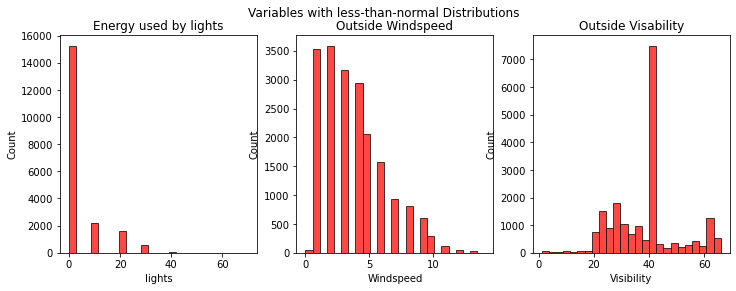

In [220]:
## Creating the plots
fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('Variables with less-than-normal Distributions')

sns.histplot(dat.lights,bins = 25, ax=axes[0])
axes[0].set_title('Energy used by lights')

sns.histplot(dat.Windspeed, bins = 25, ax=axes[1])
axes[1].set_title('Outside Windspeed')

sns.histplot(dat.Visibility, bins = 25, ax=axes[2])
axes[2].set_title('Outside Visability')

plt.show()

Lastly, we want to seperate our date variable into a binary "isWeekend" variable and a categorical set of bins for Morning, Afternoon, Evening, and Night

In [221]:
def get_weekend(dt_string):

    ## convert to a timestamp and get the day name
    date_ts = pd.Timestamp(dt_string)
    dayName = date_ts.day_name()

    ## 1 if its a weekend, 0 if not
    if dayName in ['Saturday', 'Sunday']:
        return 1
  
    else:
        return 0

def get_time_of_day(dt_string):

    ## parse the date time object
    dt_obj = datetime.strptime(dt_string, '%Y-%m-%d %H:%M:%S')
    hour = dt_obj.hour

    ## return the corresponding time of day
    if hour in range(6, 12):
        return "morning"

    elif hour in range(12, 18):
        return "afternoon"

    elif hour in range(18, 23):
        return 'evening'

    elif hour in [23, 24, 0, 1, 2, 3, 4, 5]:
        return 'night'

    return 'Something went wrong'

## now we create our two new feature columns
dat['isWeekend'] = dat['date'].apply(get_weekend)
dat['timeOfDay'] = dat['date'].apply(get_time_of_day)

## Set the datatype for the weekend var:
dat = dat.astype({"isWeekend": 'int'})


dat[['date', 'isWeekend', 'timeOfDay']].head(10)

,date,isWeekend,timeOfDay
0,2016-01-11 17:00:00,0,afternoon
1,2016-01-11 17:10:00,0,afternoon
2,2016-01-11 17:20:00,0,afternoon
3,2016-01-11 17:30:00,0,afternoon
4,2016-01-11 17:40:00,0,afternoon
5,2016-01-11 17:50:00,0,afternoon
6,2016-01-11 18:00:00,0,evening
7,2016-01-11 18:10:00,0,evening
8,2016-01-11 18:20:00,0,evening
9,2016-01-11 18:30:00,0,evening


Since there are no asusmptions/requirements in linear regression for the independant variables to be normally distributed, we will not alter the data.

From this plot, we can see that there is very little difference between Energy consumption and the type of day. We see a slight increase in energy on weekends, but not by much.

C:\Users\arbis\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\arbis\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\arbis\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


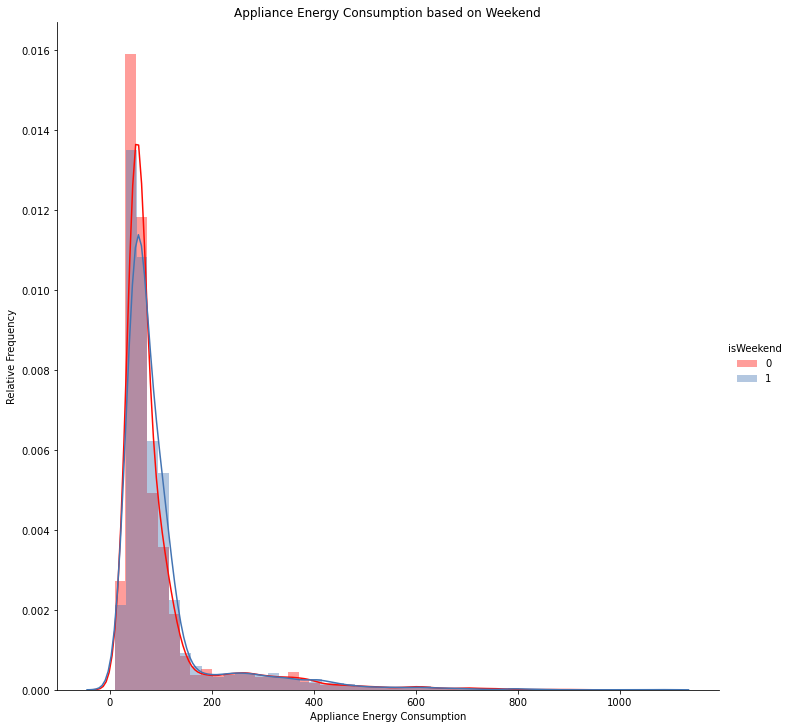

In [222]:
## Setting our color pallete
colors = ["#FF0B04", "#4374B3"]
sns.set_palette(sns.color_palette(colors))

## Our plot
sns.FacetGrid(dat,hue='isWeekend',size=10).map(sns.distplot,'Appliances').add_legend()
plt.title('Appliance Energy Consumption based on Weekend')
plt.xlabel('Appliance Energy Consumption')
plt.ylabel('Relative Frequency')
plt.show()

In [223]:
## continuing with a T-test
from scipy.stats import ttest_ind

ttest_weekend = ttest_ind(dat[dat['isWeekend'] == 1]['Appliances'], dat[dat['isWeekend'] == 0]['Appliances'])
print('With a p value of:', round(ttest_weekend[1], 4), 'we can reject the null hypothesis that the appliance consumption is different on weekdays than on weekends')

With a p value of: 0.0143 we can reject the null hypothesis that the appliance consumption is different on weekdays than on weekends


In [224]:
## Running an anova to see if there is a statistically signifigant difference in Appliance energy usage accross different times of day
from scipy.stats import f_oneway

## Seperate the dataset into 4 series of Appliance Energy Data, seperated by time of day
datMorning = dat[dat['timeOfDay'] == 'morning']['Appliances']
datAfternoon = dat[dat['timeOfDay'] == 'afternoon']['Appliances']
datEvening = dat[dat['timeOfDay'] == 'evening']['Appliances']
datNight = dat[dat['timeOfDay'] == 'night']['Appliances']

## And we run our Anova
anova_timeOfDay = f_oneway(datMorning,datAfternoon,datEvening,datNight)
print('With a F Statistic of:', round(anova_timeOfDay[0], 4), 'and an incredibly low P-value, we can reject the null hypothesis that the appliance consumption is different accross different times of the day')


With a F Statistic of: 660.0135 and an incredibly low P-value, we can reject the null hypothesis that the appliance consumption is different accross different times of the day


We can see here that there overall really weak correlation between the temperature of the Living room and the total Appliance consumption, even when seperated by time of day.

#### Overall, these correlations are fairly weak. As expected, the lights are the most correlated with Appliance use (You're more likely to be using energy-consuming appliances when the lights are on (because you're probably in the house) than when the lights are off (when you're not in the house or asleep)). Its interesting to see that humidity is just as correlated with appliance energy usage than temperature.

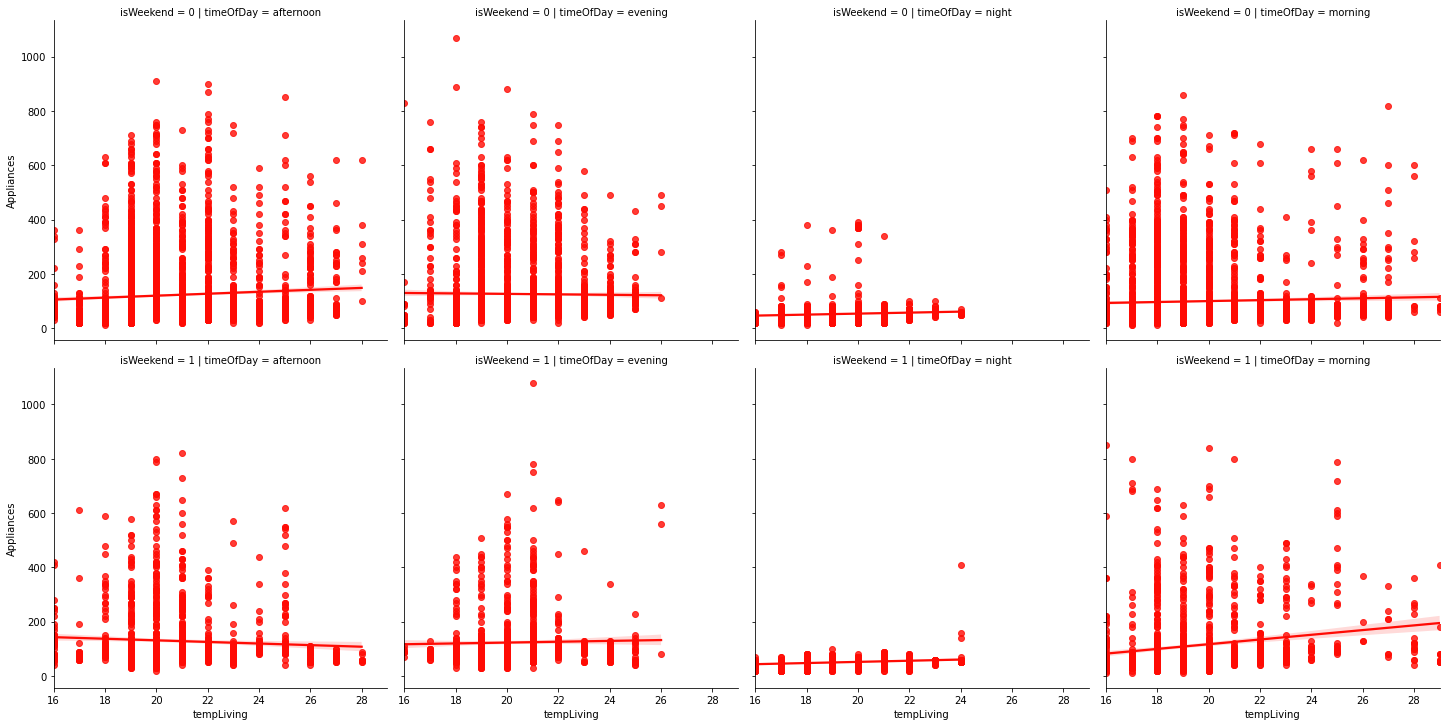

In [225]:
sns.lmplot(x="tempLiving", y="Appliances", col="timeOfDay", row = 'isWeekend', data=dat)

C:\Users\arbis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


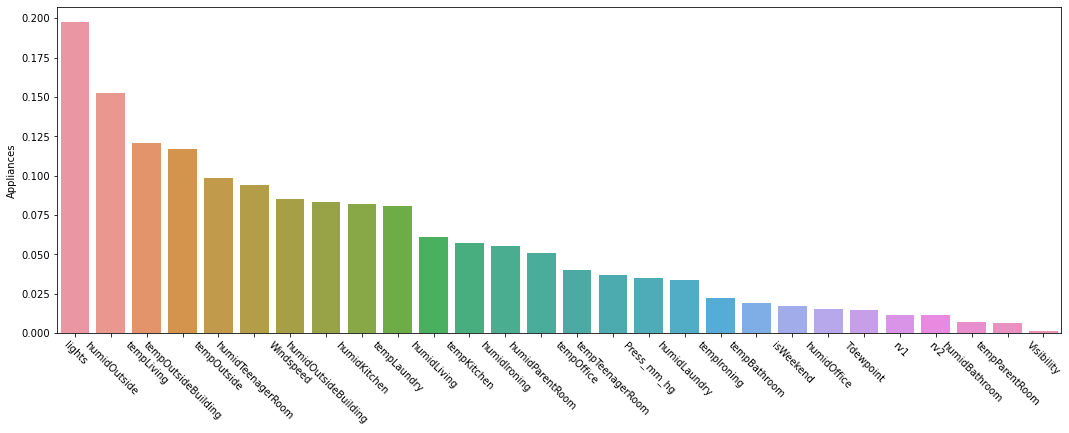

In [226]:
## We create a dataframe that holds onto the variable correlations
corr_w_Appliances = dat.corr()['Appliances']
corr_w_Appliances.columns = ['Variable', 'Correlation']

## Remove the self-correlation row and set the plot order
corr_w_Appliances = corr_w_Appliances[corr_w_Appliances.index != 'Appliances']
plot_order = abs(corr_w_Appliances).sort_values(ascending=False).index.values

## And we plot the correlations of each continous independant variable with the total Appliance energy usage
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(corr_w_Appliances.index, abs(corr_w_Appliances), order = plot_order)

ax.xaxis.set_tick_params(rotation= -45)

#### We can see that there is multicolinearity in the Data. There are some relativly strong correlations in the data, usually this relationship is between the Temperature/Humidity within a certain room and the Temperature/Humidity accross all of the other rooms. This makes sense. If its 70 degrees in the living room, its probably going to be close to 70 degrees in the bathroom.

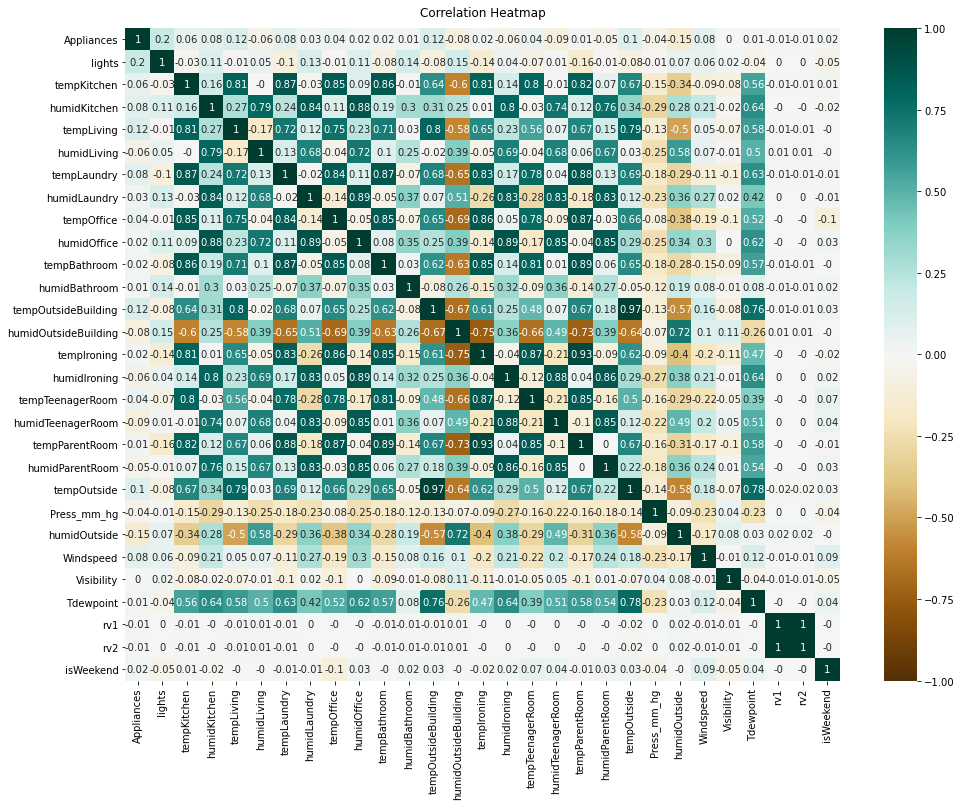

In [227]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 12))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(round(dat.corr(),2), vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Outlier analysis of independant variables

In [228]:
def count_outliers(col):

    ## get the standard deviation and mean of our feature
    sd_col = np.std(col)
    mean_col = np.mean(col)

    ## get a count of all variable further than 3 standrard deviations form the mean
    outlier_dist = mean_col + (3 * sd_col)
    ct_outlier = len(col[abs(col) > outlier_dist])

    return ct_outlier


dependant_vars = ['tempKitchen', 'humidKitchen',
       'tempLiving', 'humidLiving', 'tempLaundry', 'humidLaundry',
       'tempOffice', 'humidOffice', 'tempBathroom', 'humidBathroom',
       'tempOutsideBuilding', 'humidOutsideBuilding', 'tempIroning',
       'humidIroning', 'tempTeenagerRoom', 'humidTeenagerRoom',
       'tempParentRoom', 'humidParentRoom', 'tempOutside', 'Press_mm_hg',
       'humidOutside', 'Windspeed', 'Visibility', 'Tdewpoint']

# dat.columns
dat[dependant_vars].apply(count_outliers)

tempKitchen               0
humidKitchen            109
tempLiving              195
humidLiving              21
tempLaundry              87
humidLaundry             10
tempOffice                0
humidOffice               0
tempBathroom             26
humidBathroom           568
tempOutsideBuilding     102
humidOutsideBuilding      0
tempIroning               0
humidIroning             16
tempTeenagerRoom          0
humidTeenagerRoom         0
tempParentRoom            0
humidParentRoom           0
tempOutside             132
Press_mm_hg               0
humidOutside              0
Windspeed                73
Visibility                0
Tdewpoint                 0
dtype: int64

Since there are some relativly high counts of observations greater than 3 standard deviations from their respective means, a robust scaler will be more helpful than a standard scaler.

In [229]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
rs = RobustScaler()

dependant_var = ['Appliances']

categorical_ind_var = ['timeOfDay']
binary_ind_var = ['isWeekend']
continous_ind_vars = ['lights', 'tempKitchen', 'humidKitchen',
       'tempLiving', 'humidLiving', 'tempLaundry', 'humidLaundry',
       'tempOffice', 'humidOffice', 'tempBathroom', 'humidBathroom',
       'tempOutsideBuilding', 'humidOutsideBuilding', 'tempIroning',
       'humidIroning', 'tempTeenagerRoom', 'humidTeenagerRoom',
       'tempParentRoom', 'humidParentRoom', 'tempOutside', 'Press_mm_hg',
       'humidOutside', 'Windspeed', 'Visibility', 'Tdewpoint']

all_modeling_features = dependant_var + categorical_ind_var + binary_ind_var + continous_ind_vars

dat_clean = dat[all_modeling_features]

preprocessor = ColumnTransformer(
    [
        ('categoricals', OneHotEncoder(dtype = 'float32'), categorical_ind_var),
        ('numericals', RobustScaler(), continous_ind_vars)
    ],
    remainder = 'passthrough'
)



In [230]:
## test train split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dat_clean.loc[ : , dat_clean.columns != 'Appliances'],
                                                    dat_clean['Appliances'],  
                                                    test_size=0.2)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(15788, 27)
(3947, 27)
(15788,)
(3947,)


In [231]:
X_train.head()

,timeOfDay,isWeekend,lights,tempKitchen,humidKitchen,tempLiving,humidLiving,tempLaundry,humidLaundry,tempOffice,...,tempTeenagerRoom,humidTeenagerRoom,tempParentRoom,humidParentRoom,tempOutside,Press_mm_hg,humidOutside,Windspeed,Visibility,Tdewpoint
14821,afternoon,1,0,22,37,21,35,24,34,22,...,24,36,20,38,10,757,48,6,40,0
1883,evening,1,10,21,43,20,42,20,44,17,...,19,50,15,48,7,767,96,3,63,7
2026,evening,0,0,20,43,19,43,20,44,18,...,19,46,17,48,9,762,74,4,40,5
13318,night,0,0,21,41,19,44,24,39,22,...,22,45,21,43,5,750,89,1,40,4
12880,night,1,0,21,40,18,44,22,39,20,...,22,40,20,43,5,751,97,2,24,5


# Part 2: Modeling

For all of our modeling, we are going to:

   1) Initialize our model and get a hyperparameter grid.
   
   2) Use a Cross-Validated Grid Search to find the optimal hyperparameter set.
   
   3) Build a model using the optimal hyperparemeters.
   
   4) Calculate the mean squared error of this optimized modes.

### Fitting an Elastic Net Regression model with all posible variables

In [232]:
## Initialize the model and hyperparameters
enet = ElasticNet()
enet_params = {'enet__alpha': [0.01, 0.1, 0.25, 0.5 ,1],
               'enet__l1_ratio' : [0.01, 0.1, 0.25, 0.5, 1]}

## Create a pipeline using our preprocessor and an Elastic net regression
pipe_enet = Pipeline([('processor', preprocessor), ('enet', enet)])

## Get the optimal set of parameters
enet_search = GridSearchCV(pipe_enet, enet_params, cv = 10, verbose = 1)
enet_search.fit(X_train, y_train)

print("Best Parameters:", enet_search.best_params_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Parameters: {'enet__alpha': 0.01, 'enet__l1_ratio': 1}


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   15.9s finished


In [233]:
## We create and fit our optimized model pipeline
enet_final = Pipeline([('processor', preprocessor), ('enet', ElasticNet(alpha=0.01, l1_ratio=1))])
enet_final.fit(X_train, y_train)

## We calculate the mean squared error
y_pred_enet = enet_final.predict(X_test)
mse_enet = mean_squared_error(y_test, y_pred_enet)

print("Elastic Net (full variables) MSE:", round(mse_enet,2))

Elastic Net (full variables) MSE: 8661.76


### Fitting a Regresison model and narrow down the feautres using backwards selection

In [234]:
## Since we're using Statsmodels' OLS for backwards selection, wen cant use our pipeline.
## So we have to preprocess our features

transformed_cols = ['isMorning', 'isAfternoon', 'isEvening', 'isNight', 'isWeekend','lights', 'tempKitchen', 'humidKitchen',
       'tempLiving', 'humidLiving', 'tempLaundry', 'humidLaundry',
       'tempOffice', 'humidOffice', 'tempBathroom', 'humidBathroom',
       'tempOutsideBuilding', 'humidOutsideBuilding', 'tempIroning',
       'humidIroning', 'tempTeenagerRoom', 'humidTeenagerRoom',
       'tempParentRoom', 'humidParentRoom', 'tempOutside', 'Press_mm_hg',
       'humidOutside', 'Windspeed', 'Visibility', 'Tdewpoint']

X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns = transformed_cols)
X_test_transformed = pd.DataFrame(preprocessor.fit_transform(X_test), columns = transformed_cols)

X_train_transformed.head()

,isMorning,isAfternoon,isEvening,isNight,isWeekend,lights,tempKitchen,humidKitchen,tempLiving,humidLiving,...,tempTeenagerRoom,humidTeenagerRoom,tempParentRoom,humidParentRoom,tempOutside,Press_mm_hg,humidOutside,Windspeed,Visibility,Tdewpoint
0,1.0,0.0,0.0,0.0,0.0,0.5,-0.333333,0.333333,-0.833333,0.666667,...,-0.857143,0.5,-0.333333,0.571429,0.1,-1.666667,1.000000,0.000000,-0.500000,1.0
1,0.0,1.0,0.0,0.0,10.0,0.0,0.666667,0.000000,0.333333,-0.666667,...,1.142857,-2.0,1.333333,0.142857,1.1,0.619048,0.000000,2.090909,0.666667,1.0
2,0.0,1.0,0.0,0.0,0.0,-0.5,0.666667,-0.333333,0.500000,-0.666667,...,0.571429,-1.0,1.333333,0.428571,0.6,-0.428571,0.333333,0.000000,0.333333,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,-0.333333,0.666667,0.666667,...,0.428571,1.0,0.500000,-0.142857,-0.6,0.285714,-0.666667,0.000000,0.166667,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.166667,-0.666667,0.666667,0.000000,...,-0.285714,0.5,0.500000,-0.142857,-0.5,0.666667,-0.333333,-1.454545,0.333333,1.0


In [235]:
## creating function to get model statistics
def get_backwards_selection(cols, X_train, y_train):

    ## fit the initial linear regression
    results = sm.OLS(y_train, X_train[cols]).fit()
    pvals = results.pvalues

    ## if there are any results with a p-value greater than 0.05, remove the
    ## coeficient wtih the highest p-value and run it again
    while any(results.pvalues > 0.01):

        ## get the value with the highest p-val
        max_coef_val = results.pvalues.sort_values()[-1]
        max_coef_name = results.pvalues.sort_values().index[-1]

        ## remove it
        print('Removing:', max_coef_name, 'Pval:', str(round(max_coef_val, 3)))
        cols.remove(max_coef_name)

        ## rerun the model without it
        results = sm.OLS(y_train, X_train[cols]).fit()


    ## finally, return the summary for the regression once there are no more variables left to remove
    return results

reduced_regression = get_backwards_selection(transformed_cols, X_train_transformed, y_train.values.ravel())
reduced_regression.summary()

Removing: tempOutside Pval: 0.967
Removing: Press_mm_hg Pval: 0.928
Removing: tempOutsideBuilding Pval: 0.709
Removing: tempBathroom Pval: 0.553
Removing: humidOffice Pval: 0.396
Removing: tempParentRoom Pval: 0.327
Removing: Windspeed Pval: 0.107
Removing: humidOutsideBuilding Pval: 0.09
Removing: Visibility Pval: 0.128
Removing: lights Pval: 0.011


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     169.9
Date:                Sun, 06 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:15:02   Log-Likelihood:                -94017.
No. Observations:               15788   AIC:                         1.881e+05
Df Residuals:                   15768   BIC:                         1.882e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
isMorning           101.6598      2.227     45.651      0.000      97.295     106.025
isAfternoon          95.3248      2.282     41.764      0.000      90.851      99.799
isEvening           100.5678      2.025     49.663      0.000      96.599     104.537
isNight              56.2860      1.939     29.035      0.000      52.486      60.086
isWeekend             1.7803      0.106     16.796      0.000       1.573       1.988
tempKitchen          63.3920      3.695     17.157      0.000      56.150      70.634
humidKitchen        -31.8406      3.520     -9.045      0.000     -38.741     -24.941
tempLiving          -52.0907      3.847    -13.541      0.000     -59.631     -44.551
humidLiving          58.5088      2.782     21.031      0.000      53.056      63.962
tempLaundry          26.7011      3.359      7.949      0.000      20.117      33.285
humidLaundry         -7.6294      2.933     -2.601      0.009     -13.378      -1.881
tempOffice          -16.7642      4.462     -3.757      0.000     -25.510      -8.018
humidBathroom        22.8886      5.070      4.515      0.000      12.951      32.826
tempIroning         -13.0832      3.281     -3.987      0.000     -19.515      -6.652
humidIroning         22.2702      2.690      8.278      0.000      16.997      27.544
tempTeenagerRoom    -14.1310      2.707     -5.221      0.000     -19.436      -8.826
humidTeenagerRoom   -27.2262      2.543    -10.707      0.000     -32.211     -22.242
humidParentRoom     -18.3267      4.887     -3.750      0.000     -27.906      -8.747
humidOutside          4.6959      1.062      4.421      0.000       2.614       6.778
Tdewpoint             6.2954      1.741      3.616      0.000       2.883       9.708
==============================================================================
Omnibus:                    11170.712   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           168649.374
Skew:                           3.319   Prob(JB):                         0.00
Kurtosis:                      17.571   Cond. No.                         83.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [236]:
## We save the remaining features as significant variables
significant_vars = ['isMorning', 'isAfternoon', 'isEvening', 'isNight', 'humidLiving',
       'tempKitchen', 'tempLiving', 'isWeekend', 'humidKitchen',
       'humidTeenagerRoom', 'humidIroning', 'tempLaundry', 'humidParentRoom',
       'tempTeenagerRoom', 'humidBathroom', 'tempIroning', 'humidOutside',
       'Visibility', 'Tdewpoint', 'humidOutsideBuilding', 'Windspeed']

In [237]:
## Since the data is already transformed, we dont need to place the preprocessor into the pipeline
## We set up a (mostly empty) pipeline containing a Linear Regression Object
red_reg_final = Pipeline([('lr', LinearRegression())])
red_reg_final.fit(X_train_transformed[significant_vars], y_train)

## We calculate the Mean Sauared Error
y_pred_red_reg = red_reg_final.predict(X_test_transformed[significant_vars])
mse_lr = mean_squared_error(y_test, y_pred_red_reg)

print("Linear Regression (reduced variables) MSE:", round(mse_lr,2))

Linear Regression (reduced variables) MSE: 8832.56


In [238]:
## Lets also try runnning an Elastic net with the reduced variables
## We we create and fit our elastic net model
red_enet_final = Pipeline([('lr', ElasticNet(alpha=0.01, l1_ratio=1))])
red_enet_final.fit(X_train_transformed[significant_vars], y_train)

## We calculate the Mean Sauared Error
y_pred_enet_reg = red_enet_final.predict(X_test_transformed[significant_vars])
mse_enet_red = mean_squared_error(y_test, y_pred_enet_reg)

print("Elastic Net (reduced variables) MSE:", round(mse_enet_red,2))

Elastic Net (reduced variables) MSE: 8827.41


### XGBoost

In [239]:
## Initialize the model and hyperparameters
xgb = XGBRegressor()
xgb_params = {'xgb__booster':['gblinear', 'gbtree'],
              'xgb__eta' : [0.1, 0.25, 0.5],
              'xgb__gamma' : [0.1, 0.25, 0.5 , 1],
              'xgb__max_depth' : [2, 4, 6, 8],
              'xgb__verbosity' : [0]}

## Create a pipeline using our preprocessor and an XGBoost model
pipe_xgb = Pipeline([('processor', preprocessor), ('xgb', xgb)])
xgb_search = GridSearchCV(pipe_xgb, xgb_params, cv = 5, verbose = 2)

## We run the CV Grid Search to get the best Parameters
xgb_search.fit(X_train, y_train)
xbg_best_params = xgb_search.best_params_

print("Best Parameters:", xbg_best_params)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb

[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=4, xgb

[CV]  xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_de

[CV]  xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_de

[CV]  xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=4, xgb

[CV]  xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=2, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.1s
[CV] xgb__booster=gblinear, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=4, xgb

[CV]  xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0 
[CV] 

[CV]  xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0, total=   0.4s
[CV] xgb__booster=gbtree, xgb__eta=0.1, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0 
[CV] 

[CV]  xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0, total=   0.4s
[CV] xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0, total=   0.4s
[CV] xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0, total=   0.4s
[CV] xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosit

[CV]  xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=4, xgb__verbosity=0, total=   0.3s
[CV] xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0, total=   0.4s
[CV] xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0, total=   0.4s
[CV] xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0, total=   0.4s
[CV] xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0, total=   0.4s
[CV] xgb__booster=gbtree, xgb__eta=0.25, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosit

[CV]  xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0, total=   0.5s
[CV] xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0, total=   0.5s
[CV] xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0, total=   0.5s
[CV] xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=6, xgb__verbosity=0, total=   0.5s
[CV] xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=8, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=8, xgb__verbosity=0, total=   0.7s
[CV] xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.1, xgb__max_depth=8, xgb__verbosity=0 
[CV] 

[CV]  xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0, total=   0.5s
[CV] xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0, total=   0.5s
[CV] xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=6, xgb__verbosity=0, total=   0.5s
[CV] xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=8, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=8, xgb__verbosity=0, total=   0.7s
[CV] xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=8, xgb__verbosity=0 
[CV]  xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=8, xgb__verbosity=0, total=   0.7s
[CV] xgb__booster=gbtree, xgb__eta=0.5, xgb__gamma=0.5, xgb__max_depth=8, xgb__verbosity=0 
[CV] 

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  2.0min finished


Best Parameters: {'xgb__booster': 'gbtree', 'xgb__eta': 0.25, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__verbosity': 0}


In [240]:
## We create and fit our optimized model pipeline
xgb_final = Pipeline([('processor', preprocessor),
                      ('enet', XGBRegressor(booster='gbtree',
                                            eta= 0.25,
                                            gamma = 1,
                                            max_depth = 8,
                                            verbosity = 0))])

xgb_final.fit(X_train, y_train)

## We calculate the mean squared error
y_pred_xgb = xgb_final.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print("XGBoost (full variables) MSE:", round(mse_xgb,2))


XGBoost (full variables) MSE: 5116.22


## Final Model Rankings  (Mean Squared Error)

In [241]:
## Get a dictionary of our results 
dict_results = {"XGBosst (All Variables)" : round(mse_xgb,2),
               "Elastic Net (All Variables)" :  round(mse_enet,2),
               "Linear Regression (Reduced Variables)" : round(mse_lr,2),
                "Elastic Net (Reduced Variables)" : round(mse_enet_red,2)}

## Set Create our Dataframe and calculate the Mean Squared Error
results_df = pd.DataFrame(data=dict_results.items(), columns = ['Variable', 'MSE'])
results_df = results_df.set_index('Variable')
results_df['RMSE'] = round(np.sqrt(results_df['MSE']),2)

## Sort the Dataframe
results_df.sort_values(by=['MSE'])

,MSE,RMSE
Variable,,
XGBosst (All Variables),5116.22,71.53
Elastic Net (All Variables),8661.76,93.07
Elastic Net (Reduced Variables),8827.41,93.95
Linear Regression (Reduced Variables),8832.56,93.98


### Variable Importance (Enet coef size/XGB importance)

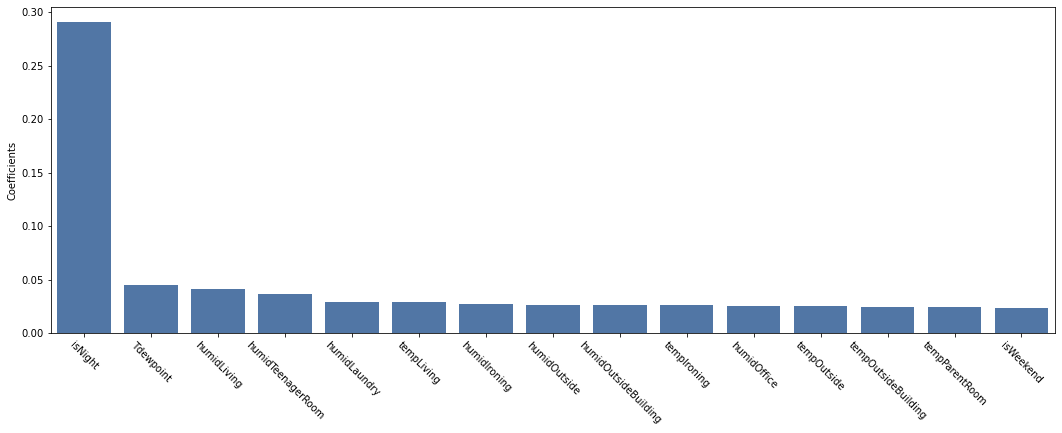

In [242]:
## We recreate our final XGBoost model object
xgb = XGBRegressor(booster='gbtree',
                   eta= 0.1,
                   gamma = 0.25,
                   max_depth = 8,
                   verbosity = 0)

xgb.fit(X_train_transformed, y_train)


## Get the top 15 variable importances
xgb_coefs = pd.DataFrame(xgb.feature_importances_, X_train_transformed.columns, columns=['Coefficients'])
top_15_xgb = xgb_coefs.nlargest(15, 'Coefficients')

## And we plot the variable importance plot
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x = top_15_xgb.index,
            y = top_15_xgb.Coefficients,
            color = "#4374B3")

ax.xaxis.set_tick_params(rotation= -45)


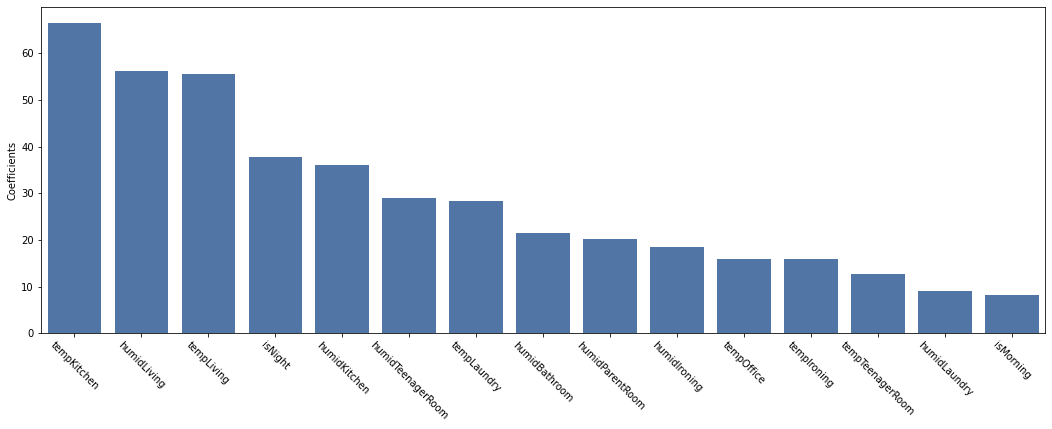

In [243]:
## We recreate our final Elastic Net model object
enet = ElasticNet(alpha=0.01,
                  l1_ratio=1)
enet.fit(X_train_transformed, y_train)

## Get the top 15 absolutey value coeficients
enet_coefs = pd.DataFrame(abs(enet.coef_), X_train_transformed.columns, columns=['Coefficients'])
top_15_enet = enet_coefs.nlargest(15, 'Coefficients')

## And we plot the variable importance plot
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x = top_15_enet.index,
            y = top_15_enet.Coefficients,
            color = "#4374B3")

ax.xaxis.set_tick_params(rotation= -45)

## Conclusion:

Overall, this data had some issues that made it difficult to effectivly fit a model. The outcome variable had a reasonably heavy right skew, and all of the continous features had rather low correlations with total Energy usage accross appliances in the house. Additionally, there was issues with multicoliniarity with the data. Thankfully, there were no nulls in the data that we had to deal with (although the higher multicoliniarity would have made regression-imputation viable).

We found that a boxcox transofmration was best for making our dependant variable more normally distrubited. Using a Log transformation did mitigate a lot of the right skewness, but there was still a significant right tail after log transformation. Additionally, there was a lot of outliers in the data, so this would go best with a more outlier-resiliant scaler (like robust scaler)

Extreme Gradient Boosting models performed much better than any of the linear regression models. We saw a drop in Mean Squared Error by 43% When we used XGBoost over the next best modeling (Elastic Net). When we looked for the optimal hyperparameters, we noticed that less penalized regression models had the best results. Additionally, deeper trees tended to make for better XGBoost models. This suggests that overfitting was not as large of an issue, and less generalizable models (deeper trees and less coeficient penalties) performed better in cross-validation testing. When it came to variable importance and coeficient size, we saw that there was not a lot of overlap between XGBoost models and Elastic Net models. 

We can say that there isn't that heavy of a relationship between weather conditions throughout a house and the overall appliance energy consumption in that house. If we had to model this relationship, it would not be particualtly effective, that said, tree-based models would be better than Linear models in a classic Train/Validate/Test setup.